Group 6

Santosh Kumar

Denis Mulabegovic

Thomas Geraci

Data Analytics and Internet of Things (AAI-530-03)

University of San Diego

Professor An Tran

AI assistance disclosure: ChatGPT was used for debugging support and to verify the Tableau CSV export format. The team authored, ran, and validated all code and results.

In [71]:
import os
import math
import glob
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Thomas
#Reproducibility: we set seeds so that training runs are more consistent across executions.
#This does not make deep learning perfectly deterministic on every machine/GPU, but it helps.
import random
random.seed(42)
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

#If a GPU is available, TensorFlow will use it automatically. This call is only informational.
tf.config.list_physical_devices("GPU")

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers, callbacks, models

### Data Processing Design Choices

We designed the data processing workflow to be reproducible from a fresh clone while still allowing fast local iteration during development. The notebook supports both a local dataset folder and a ZIP fallback so the same code can run in different environments without manual rewrites. We load a controllable number of CSV files first to validate the pipeline quickly, then scale up once the logic is confirmed and memory use is understood. Timestamps are converted early and enforced as a sorted DateTimeIndex so resampling, feature creation, and time ordered evaluation remain leakage safe. We resample to an hourly cadence to reduce high frequency noise, align sensors to a consistent interval for modeling and Tableau, and make daily patterns easier to analyze. Missing values are handled explicitly to avoid biased metrics and unstable training, and quick plots are included as sanity checks to confirm the cleaned signals still reflect expected seasonality and ranges before training models.

In [72]:
#Denis
#Design choice: see 'Denis Data Processing Design Choices' section above.
#Local dataset folder (Windows) REMOVE WHEN DONE 
LOCAL_DATA_DIR = 

def _find_best_csv_dir(root: str):
    direct = glob.glob(os.path.join(root, "*.csv"))
    if direct:
        return root

    recursive = glob.glob(os.path.join(root, "**", "*.csv"), recursive=True)
    if not recursive:
        return None

    #Pick the directory with the most CSVs (best guess)
    from collections import Counter
    counts = Counter(os.path.dirname(p) for p in recursive)
    return counts.most_common(1)[0][0]

#Path variables used by the rest of the notebook
ZIP_FILE = os.path.join("data", "raw", "bristol_data.zip")
EXTRACT_DIR = os.path.join("data", "raw")

# 1) Prefer local data (no internet needed)
DATA_CSV_FILES_PATH = None
if os.path.exists(LOCAL_DATA_DIR):
    best = _find_best_csv_dir(LOCAL_DATA_DIR)
    if best is not None:
        DATA_CSV_FILES_PATH = best
        print("Using LOCAL dataset folder:", DATA_CSV_FILES_PATH)
    else:
        print("Local dataset folder found, but no CSV files detected under it.")
        print("Double-check the folder contents or point LOCAL_DATA_DIR to the folder that contains the CSVs.")
else:
    print("Local dataset folder not found:", LOCAL_DATA_DIR)
    print("Will use download fallback (requires gdown).")

# 2) If local not available, download ZIP from Google Drive (fallback)
if DATA_CSV_FILES_PATH is None:
    try:
        import gdown
    except ModuleNotFoundError as e:
        raise ModuleNotFoundError(
            "gdown is not installed, and local CSVs were not found.\n"
            "Fix options:\n"
            "  (A) Install gdown:  pip install gdown\n"
            "  (B) Point LOCAL_DATA_DIR to a folder that contains the dataset CSV files\n"
            f"Local path checked: {LOCAL_DATA_DIR}"
        ) from e

    if not os.path.exists(ZIP_FILE):
        print("Downloading dataset ZIP (fallback) ...")
        os.makedirs(os.path.dirname(ZIP_FILE), exist_ok=True)

        #Google Drive file ID from the shareable link:
        file_id = "1OKuG5bV5ZCduGIkmiStL3kI4Ixa7f9Ss"
        gdown.download(f"https://drive.google.com/uc?id={file_id}", ZIP_FILE, quiet=False)
    else:
        print("ZIP already downloaded:", ZIP_FILE)

Using LOCAL dataset folder: C:\Users\tommy\OneDrive\Desktop\AAI 530\IoT Final Project Dataset\files_csv


### Extract CSV data files (only used if downloading)

In [73]:
#Denis
if DATA_CSV_FILES_PATH is not None:
    print("Local CSV path already set. Skipping ZIP extraction.")
else:
    extract_dir = "data/raw/csv"
    zip_file = ZIP_FILE 

    if os.path.exists(zip_file):
        #Extract only if target folder is missing/empty
        needs_extract = (not os.path.exists(extract_dir)) or (len(os.listdir(extract_dir)) == 0)

        if needs_extract:
            print(f"Extracting {zip_file} -> {extract_dir} ...")
            os.makedirs(extract_dir, exist_ok=True)
            with zipfile.ZipFile(zip_file, "r") as z:
                z.extractall(extract_dir)
            print("Extraction complete.")
        else:
            print("Extraction folder already populated:", extract_dir)

        #Sets CSV directory for later steps
        def _find_best_csv_dir(root: str):
            direct = glob.glob(os.path.join(root, "*.csv"))
            if direct:
                return root
            recursive = glob.glob(os.path.join(root, "**", "*.csv"), recursive=True)
            if not recursive:
                return None
            from collections import Counter
            counts = Counter(os.path.dirname(p) for p in recursive)
            return counts.most_common(1)[0][0]

        DATA_CSV_FILES_PATH = _find_best_csv_dir(extract_dir)
        if DATA_CSV_FILES_PATH:
            print("Using extracted dataset directory:")
            print(DATA_CSV_FILES_PATH)
        else:
            raise FileNotFoundError(
                f"No CSV files found after extraction. Check contents of: {extract_dir}"
            )
    else:
        raise FileNotFoundError(
            f"ZIP file not found at {zip_file}. Either set LOCAL_DATA_DIR correctly or download the ZIP."
        )

Local CSV path already set. Skipping ZIP extraction.


In [74]:
#Denis
files = glob.glob(os.path.join(DATA_CSV_FILES_PATH, "*.csv"))
if len(files) == 0:
    files = glob.glob(os.path.join(DATA_CSV_FILES_PATH, "**", "*.csv"), recursive=True)

print(f"Found {len(files)} CSV files")
files[:5]

Found 3471 CSV files


['C:\\Users\\tommy\\OneDrive\\Desktop\\AAI 530\\IoT Final Project Dataset\\files_csv\\2022_02_11_13-45-52_data.csv',
 'C:\\Users\\tommy\\OneDrive\\Desktop\\AAI 530\\IoT Final Project Dataset\\files_csv\\2022_02_11_14-42-55_data.csv',
 'C:\\Users\\tommy\\OneDrive\\Desktop\\AAI 530\\IoT Final Project Dataset\\files_csv\\2022_02_11_15-40-28_data.csv',
 'C:\\Users\\tommy\\OneDrive\\Desktop\\AAI 530\\IoT Final Project Dataset\\files_csv\\2022_02_11_16-39-02_data.csv',
 'C:\\Users\\tommy\\OneDrive\\Desktop\\AAI 530\\IoT Final Project Dataset\\files_csv\\2022_02_11_17-37-04_data.csv']

In [75]:
#Denis
#Tune between 50-200, make sure you have the RAM for it
N_FILES_TO_LOAD = 100

#Sort files for chronological order
files_sorted = sorted(files)

usecols = ["Time", "DeviceId", "Sensor", "Value"]
dtypes = {"DeviceId": "string", "Sensor": "string", "Value": "float32"}

selected_files = files_sorted[:min(N_FILES_TO_LOAD, len(files_sorted))]
print(f"Loading {len(selected_files)} CSV files out of {len(files_sorted)} total...")

df_list = []
for fpath in selected_files:
    try:
        df_part = pd.read_csv(fpath, usecols=usecols, dtype=dtypes)
        df_list.append(df_part)
    except Exception as e:
        print("Skipping file due to read error:", os.path.basename(fpath), "->", e)

df = pd.concat(df_list, ignore_index=True)
print("Loaded rows:", len(df))
df.head()

Loading 100 CSV files out of 3471 total...
Loaded rows: 2186792


,Time,DeviceId,Sensor,Value
0,1644587153,D,Temperature,22.555000
1,1644587153,D,Humidity,25.330000
2,1644587153,D,Pressure,102756.000000
3,1644587153,D,Gas,523.682007
4,1644587153,D,Accelerometer,0.000000


In [76]:
#Denis
df.info()
df.describe(include="all")
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186792 entries, 0 to 2186791
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Time      int64  
 1   DeviceId  string 
 2   Sensor    string 
 3   Value     float32
dtypes: float32(1), int64(1), string(2)
memory usage: 58.4 MB


Index(['Time', 'DeviceId', 'Sensor', 'Value'], dtype='object')

In [77]:
#Denis
df["timestamp"] = pd.to_datetime(df["Time"], unit="s")
df = df.drop(columns=["Time"])
df[["timestamp"]].head()

,timestamp
0,2022-02-11 13:45:53
1,2022-02-11 13:45:53
2,2022-02-11 13:45:53
3,2022-02-11 13:45:53
4,2022-02-11 13:45:53


In [78]:
#Denis
df["Sensor"].value_counts()

Sensor
Temperature      273349
Humidity         273349
Pressure         273349
Gas              273349
Accelerometer    273349
Light            273349
MIC              273349
RSSI             273349
Name: count, dtype: Int64

In [79]:
#Denis
device_id = df["DeviceId"].value_counts().idxmax()
print("Selected device:", device_id)

df_dev = df[df["DeviceId"] == device_id].copy()
df_dev["Sensor"].value_counts()

Selected device: D


Sensor
Temperature      34560
Humidity         34560
Pressure         34560
Gas              34560
Accelerometer    34560
Light            34560
MIC              34560
RSSI             34560
Name: count, dtype: Int64

In [80]:
#Denis
df_wide = df_dev.pivot_table(
    index="timestamp",
    columns="Sensor",
    values="Value",
    aggfunc="mean"
)

df_wide = df_wide.sort_index()
df_wide.head()

Sensor,Accelerometer,Gas,Humidity,Light,MIC,Pressure,RSSI,Temperature
timestamp,,,,,,,,
2022-02-11 13:45:53,0.0,523.682007,25.330000,1579.0,3.0,102756.0,58.0,22.555
2022-02-11 13:46:03,0.0,518.862000,25.278000,1573.0,3.0,102756.0,58.0,22.545
2022-02-11 13:46:13,0.0,504.425995,25.231001,1572.0,3.0,102758.0,58.0,22.545
2022-02-11 13:46:23,0.0,500.174011,25.236000,1598.0,3.0,102759.0,58.0,22.555
2022-02-11 13:46:33,0.0,503.358002,25.264000,1602.0,2.0,102756.0,58.0,22.545


In [81]:
#Denis
df_wide.isna().mean().sort_values(ascending=False)

Sensor
Accelerometer    0.000029
Gas              0.000029
Humidity         0.000029
Light            0.000029
MIC              0.000029
Pressure         0.000029
RSSI             0.000029
Temperature      0.000029
dtype: float64

In [82]:
#Denis
df_5min = df_wide.resample("5min").mean()

In [83]:
#Denis
needed_cols = ["Temperature", "Humidity", "Light", "RSSI"]
df_5min = df_5min[needed_cols].copy()

#Interpolate small gaps + forward/back fill remaining
df_5min = df_5min.interpolate(limit=12, limit_direction="both") 
df_5min = df_5min.ffill().bfill()

#If any NaNs remain, drop them
df_5min = df_5min.dropna()
print("df_5min shape after fill:", df_5min.shape)

df_5min shape after fill: (1158, 4)


In [84]:
#Denis
df_5min.head()

Sensor,Temperature,Humidity,Light,RSSI
timestamp,,,,
2022-02-11 13:45:00,22.627399,25.411480,1498.640015,55.200001
2022-02-11 13:50:00,22.573334,25.320200,1376.133301,54.000000
2022-02-11 13:55:00,22.499332,25.254499,1527.900024,56.166668
2022-02-11 14:00:00,22.480999,25.061768,1715.599976,54.833332
2022-02-11 14:05:00,22.452000,25.045433,1840.933350,53.500000


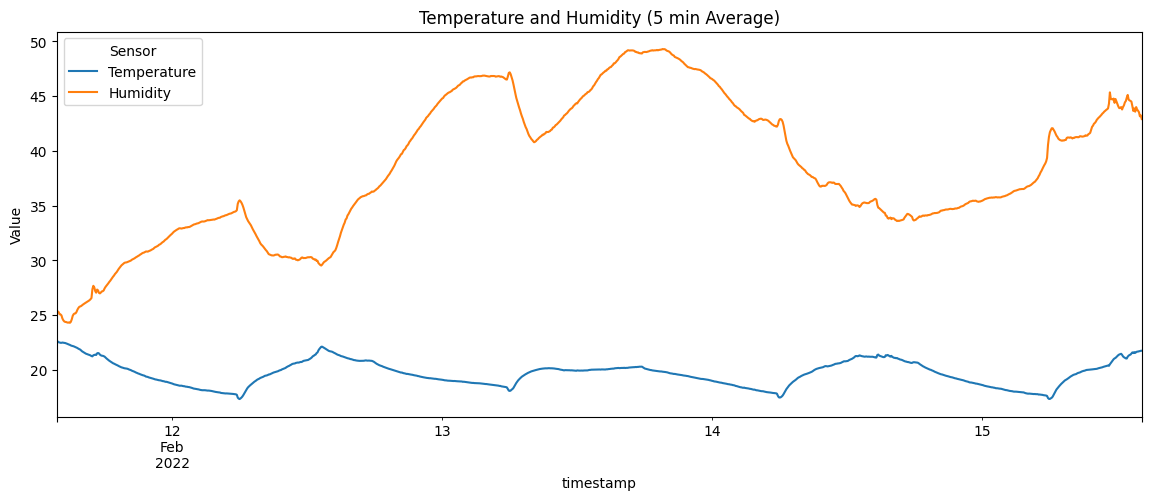

In [85]:
#Denis
df_5min[["Temperature", "Humidity"]].plot(
    figsize=(14,5),
    title="Temperature and Humidity (5 min Average)"
)
plt.ylabel("Value")
plt.show()

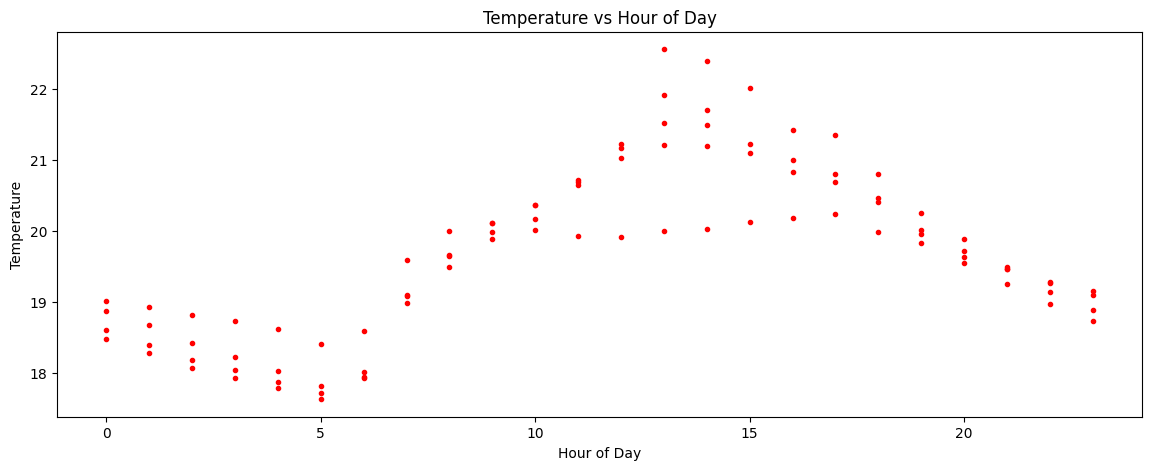

In [86]:
#Denis
df_hourly = df_5min.resample("1h").mean()

plt.figure(figsize=(14,5))
plt.plot(df_hourly.index.hour, df_hourly["Temperature"], ".", color='red')
plt.xlabel("Hour of Day")
plt.ylabel("Temperature")
plt.title("Temperature vs Hour of Day")
plt.show()

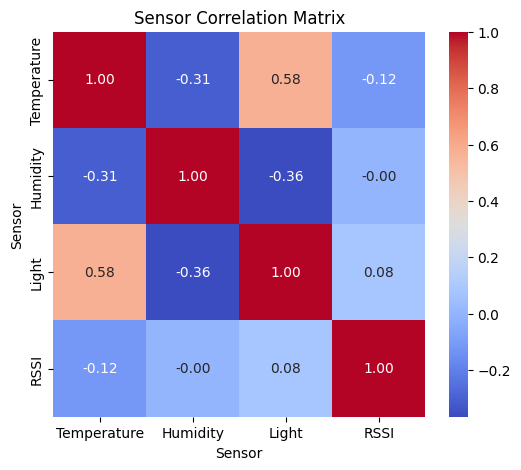

In [87]:
#Denis
corr_df = df_5min[["Temperature", "Humidity", "Light", "RSSI"]] 
corr = corr_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Sensor Correlation Matrix")
plt.show()

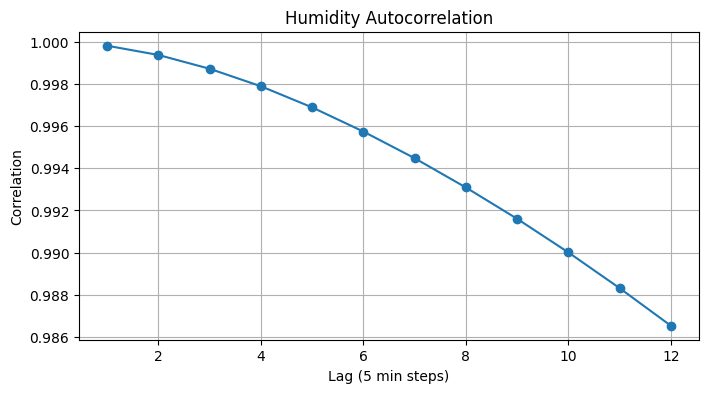

In [88]:
#Denis
lags = range(1, 13)
lag_corrs = [
    df_5min["Humidity"].corr(df_5min["Humidity"].shift(lag))
    for lag in lags
]

plt.figure(figsize=(8,4))
plt.plot(lags, lag_corrs, marker="o")
plt.xlabel("Lag (5 min steps)")
plt.ylabel("Correlation")
plt.title("Humidity Autocorrelation")
plt.grid(True)
plt.show()

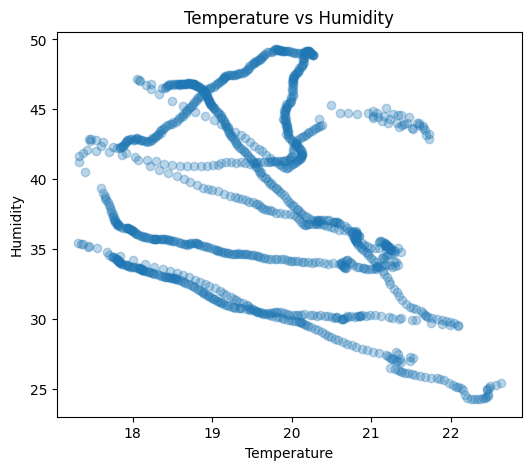

In [89]:
#Denis
plt.figure(figsize=(6,5))
plt.scatter(df_5min["Temperature"], df_5min["Humidity"], alpha=0.3)
plt.xlabel("Temperature")
plt.ylabel("Humidity")
plt.title("Temperature vs Humidity")
plt.show()

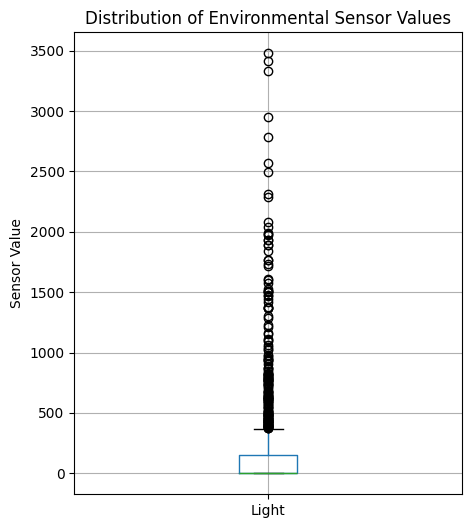

In [90]:
#Denis
plt.figure(figsize=(5,6))
df_5min[["Light"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

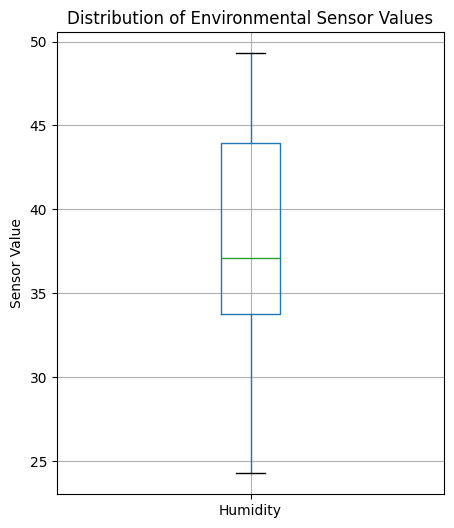

In [91]:
#Denis
plt.figure(figsize=(5,6))
df_5min[["Humidity"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

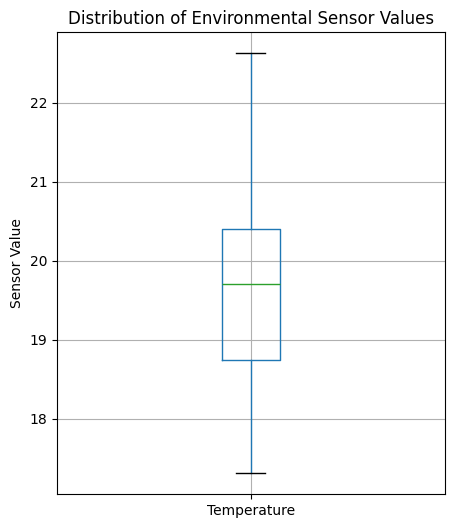

In [92]:
#Denis
plt.figure(figsize=(5,6))
df_5min[["Temperature"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

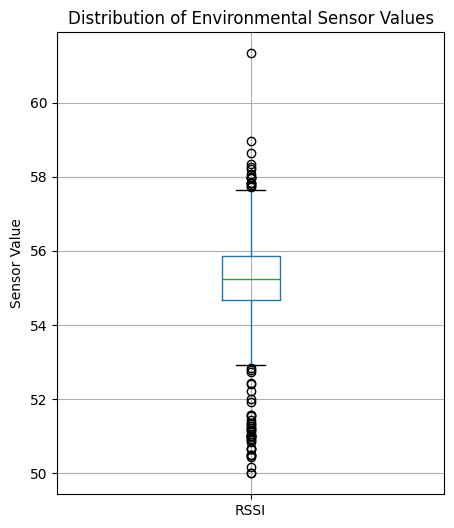

In [93]:
#Denis
plt.figure(figsize=(5,6))
df_5min[["RSSI"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

### EDA and Preprocessing Output Analysis

These preprocessing outputs were designed to make the downstream modeling and dashboard steps trustworthy by ensuring that every sensor signal is aligned to the same timeline and that the assumptions about sampling frequency are explicit. We resample to an hourly cadence because it reduces high frequency noise and makes patterns like daily cycles easier to learn, while still preserving enough resolution to forecast near term changes. We also keep the pipeline reproducible by using the same cleaned dataframe for both models, which avoids accidental differences in feature construction that could confuse results. The EDA checks were included to justify these choices by showing the distribution of readings, the presence of missingness or dropouts, and the diurnal structure that motivated including time based features in the random forest and temporal windows in the LSTM. In practice, when the cleaned dataframe has a datetime index, the resampled frequency is consistent, and the plots show stable trends rather than erratic spikes from misalignment, that confirms the processing stage is doing what it is supposed to do and that the modeling results can be interpreted with confidence.


### IoT System Diagram and Data Flow Output Analysis

We included the IoT system diagram and data flow explanation to justify why the analytics pipeline is structured the way it is and to connect the dataset to a realistic operational context. The diagram clarifies where sensor readings are generated, how they would be transmitted and stored, and where quality issues such as packet loss, irregular sampling, or sensor drift are likely to appear, which is exactly why the preprocessing stage emphasizes timestamp normalization and missing value handling. It also explains why forecasting is useful in an IoT setting, because predictions can support proactive decisions such as detecting emerging anomalies, planning maintenance, or managing energy and comfort tradeoffs. By mapping each project artifact to a stage in the pipeline, the documentation makes it clear that the models are not isolated exercises but are designed to sit on top of a repeatable ingestion and cleaning workflow and to feed results into a dashboard that an operator could realistically use.


In [94]:
#Thomas
#Model Preprocessing for LSTM
model_df = df_5min[[
    "Temperature",
    "Humidity",
    "Light",
    "RSSI"
]].copy()

model_df.head()

Sensor,Temperature,Humidity,Light,RSSI
timestamp,,,,
2022-02-11 13:45:00,22.627399,25.411480,1498.640015,55.200001
2022-02-11 13:50:00,22.573334,25.320200,1376.133301,54.000000
2022-02-11 13:55:00,22.499332,25.254499,1527.900024,56.166668
2022-02-11 14:00:00,22.480999,25.061768,1715.599976,54.833332
2022-02-11 14:05:00,22.452000,25.045433,1840.933350,53.500000


In [95]:
#Thomas
#Train and Validation Split for LSTM
split_point = int(len(model_df) * 0.8)
train_df = model_df.iloc[:split_point]
val_df = model_df.iloc[split_point:]

In [96]:
#Thomas
#Scaling for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)

### Sequence Generation for LSTM
Design choice:
We use a sliding window of past readings to predict the next Temperature value. Because we resample to hourly earlier, a window=12 corresponds to the last 12 hours of context. We keep the split time-ordered to avoid leakage (training never sees future information).

In [97]:
#Thomas
#Sequence Generation for LSTM
def build_supervised_sequences(arr: np.ndarray, target_index: int, window: int = 12):
    if arr.ndim != 2:
        raise ValueError("Expected a 2D array shaped (time, features).")
    if window < 2:
        raise ValueError("window should be at least 2 for meaningful sequence learning.")
    if not (0 <= target_index < arr.shape[1]):
        raise ValueError("target_index out of range for provided feature matrix.")

    n = arr.shape[0]
    X = np.empty((max(n - window, 0), window, arr.shape[1]), dtype=np.float32)
    y = np.empty((max(n - window, 0),), dtype=np.float32)

    #We predict the value at t=window using the window values from [0..window-1], then slide forward.
    for t in range(n - window):
        X[t] = arr[t : t + window]
        y[t] = arr[t + window, target_index]

    return X, y

temp_idx = model_df.columns.get_loc("Temperature")

x_train, y_train = build_supervised_sequences(train_scaled, target_index=temp_idx, window=12)
x_val, y_val = build_supervised_sequences(val_scaled, target_index=temp_idx, window=12)

### LSTM Architecture Rationale
Design choice: Two LSTM layers: the first learns broad temporal patterns, the second refines a compact representation. Dropout is included to reduce overfitting since time series windows can be highly autocorrelated. A small dense head maps the learned sequence representation to a single next-step prediction.

In [98]:
#Thomas
#Shapes: (samples, window, features)
print("x_train shape:", x_train.shape, "| y_train shape:", y_train.shape)
print("x_val shape  :", getattr(x_val, "shape", None),   "| y_val shape  :", getattr(y_val, "shape", None))

window = x_train.shape[1]
n_features = x_train.shape[2]

lstm_model = models.Sequential(
    [
        layers.Input(shape=(window, n_features)),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.20),
        layers.LSTM(32),
        layers.Dense(16, activation="relu"),
        layers.Dense(1),
    ]
)

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

history = lstm_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=25,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
)

x_train shape: (914, 12, 4) | y_train shape: (914,)
x_val shape  : (220, 12, 4) | y_val shape  : (220,)
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1360 - mae: 0.3003 - val_loss: 0.0851 - val_mae: 0.2579
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0223 - mae: 0.1205 - val_loss: 0.0238 - val_mae: 0.1421
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0066 - mae: 0.0652 - val_loss: 0.0124 - val_mae: 0.1044
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - mae: 0.0495 - val_loss: 0.0069 - val_mae: 0.0756
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - mae: 0.0409 - val_loss: 0.0028 - val_mae: 0.0413
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - mae: 0.0342 - val_loss: 0.0021 - val_mae: 0.0375
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - mae: 0.0339 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - mae: 0.03

                     actual_temperature  pred_temperature  temp_abs_error
timestamp                                                                
2022-02-14 19:55:00           19.745000         19.868039        0.123038
2022-02-14 20:00:00           19.704668         19.828937        0.124269
2022-02-14 20:05:00           19.670332         19.794912        0.124580
2022-02-14 20:10:00           19.639667         19.761450        0.121783
2022-02-14 20:15:00           19.598665         19.720725        0.122060


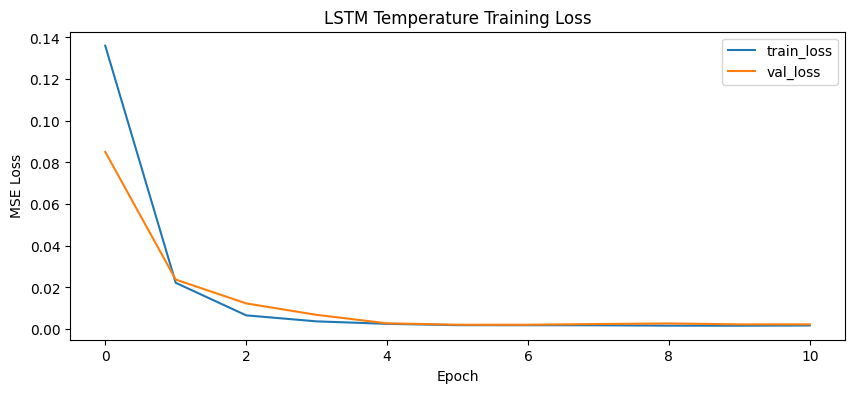

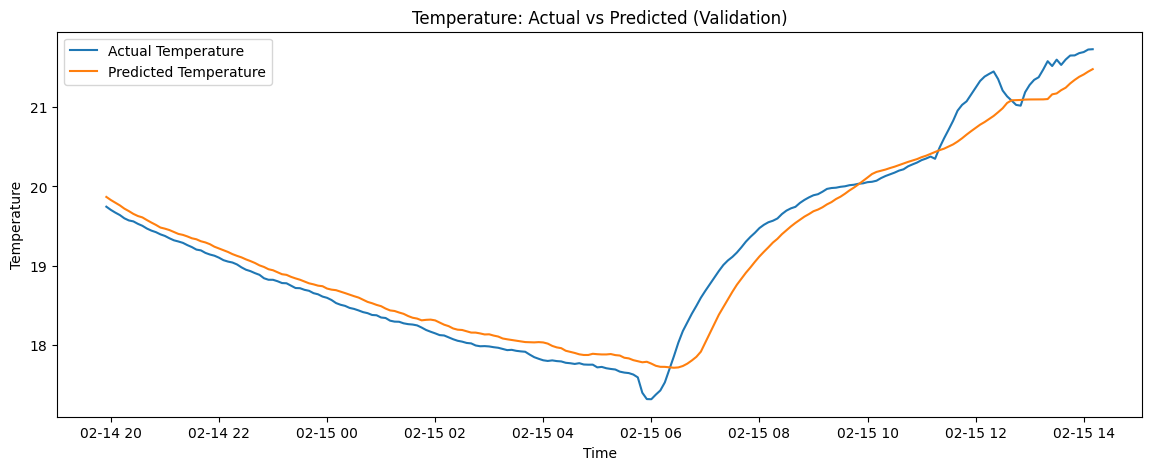

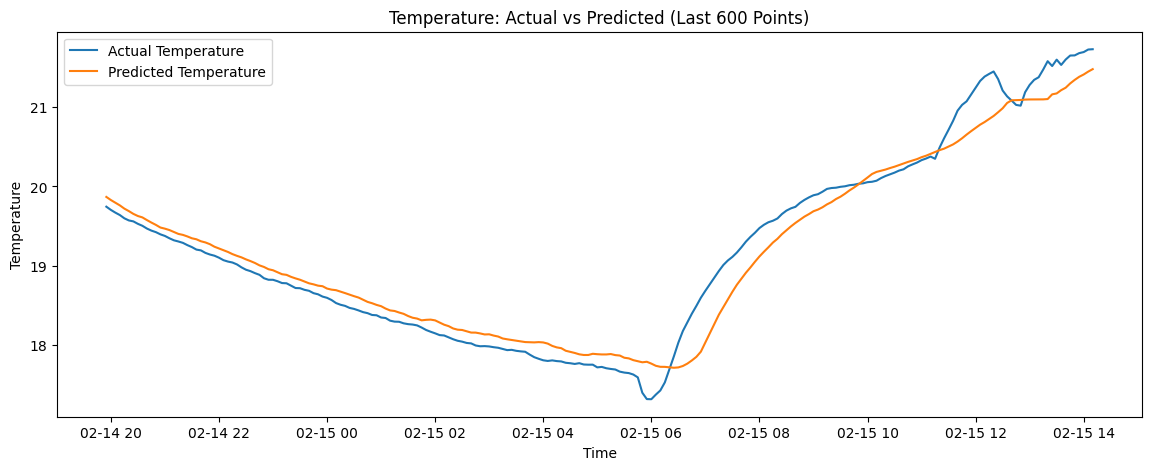

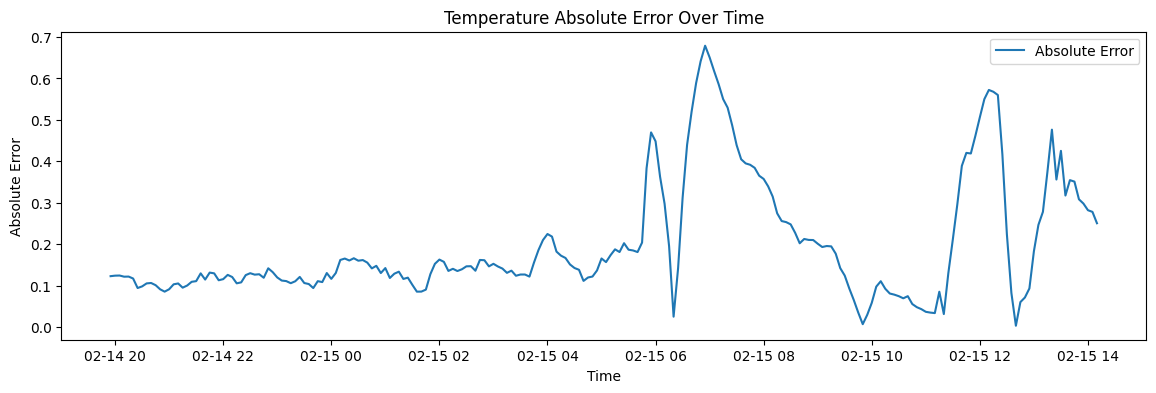

In [99]:
#Thomas
#Temperature LSTM Results + Charts

window = x_train.shape[1]
n_features = x_train.shape[2]
temp_idx = model_df.columns.get_loc("Temperature")

#Predicts on validation sequences
y_pred_scaled = lstm_model.predict(x_val, verbose=0).reshape(-1)
y_true_scaled = y_val.reshape(-1)

#Robust inverse scaling for just the Temperature
def invert_single_feature(scaler, scaled_vec, feature_index, n_features):
    tmp = np.zeros((len(scaled_vec), n_features), dtype=float)
    tmp[:, feature_index] = scaled_vec
    inv = scaler.inverse_transform(tmp)
    return inv[:, feature_index]

y_pred_temp = invert_single_feature(scaler, y_pred_scaled, temp_idx, n_features)
y_true_temp = invert_single_feature(scaler, y_true_scaled, temp_idx, n_features)

#Build aligned timestamps for y at t+window
temp_ts = val_df.index[window: window + len(y_true_temp)]

temp_results = pd.DataFrame({
    "timestamp": pd.to_datetime(temp_ts),
    "actual_temperature": y_true_temp,
    "pred_temperature": y_pred_temp
}).set_index("timestamp")

temp_results["temp_abs_error"] = (temp_results["actual_temperature"] - temp_results["pred_temperature"]).abs()

print(temp_results.head())

#Plot 1: Loss curves
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("LSTM Temperature Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

#Plot 2: Actual vs Predicted
plt.figure(figsize=(14,5))
plt.plot(temp_results.index, temp_results["actual_temperature"], label="Actual Temperature")
plt.plot(temp_results.index, temp_results["pred_temperature"], label="Predicted Temperature")
plt.title("Temperature: Actual vs Predicted (Validation)")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Plot 3: Zoomed last N points for readability
N = 600  
tail = temp_results.tail(N)

plt.figure(figsize=(14,5))
plt.plot(tail.index, tail["actual_temperature"], label="Actual Temperature")
plt.plot(tail.index, tail["pred_temperature"], label="Predicted Temperature")
plt.title(f"Temperature: Actual vs Predicted (Last {N} Points)")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Plot 4: Error over time
plt.figure(figsize=(14,4))
plt.plot(temp_results.index, temp_results["temp_abs_error"], label="Absolute Error")
plt.title("Temperature Absolute Error Over Time")
plt.xlabel("Time")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()

Temperature MAE  : 0.1992
Temperature RMSE : 0.2449
Temperature R^2  : 0.9583


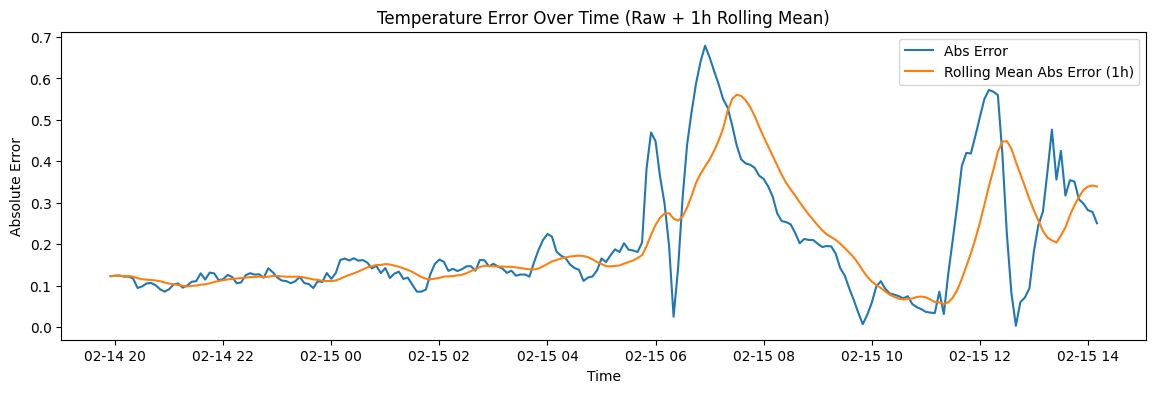

In [100]:
#Thomas
#Temperature Metrics Validation and Rolling Error 

#temp_results is created in the previous cell
mae = float(np.mean(np.abs(temp_results["actual_temperature"] - temp_results["pred_temperature"])))
rmse = float(np.sqrt(np.mean((temp_results["actual_temperature"] - temp_results["pred_temperature"])**2)))

#Simple R^2
y = temp_results["actual_temperature"].values
yhat = temp_results["pred_temperature"].values
ss_res = np.sum((y - yhat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = float(1 - ss_res/ss_tot) if ss_tot != 0 else float("nan")

print(f"Temperature MAE  : {mae:.4f}")
print(f"Temperature RMSE : {rmse:.4f}")
print(f"Temperature R^2  : {r2:.4f}")

#Rolling mean absolute error 
window_points = 12  #12 * 5min = 60 minutes
temp_results["temp_abs_error_roll_1h"] = temp_results["temp_abs_error"].rolling(window_points, min_periods=1).mean()

plt.figure(figsize=(14,4))
plt.plot(temp_results.index, temp_results["temp_abs_error"], label="Abs Error")
plt.plot(temp_results.index, temp_results["temp_abs_error_roll_1h"], label="Rolling Mean Abs Error (1h)")
plt.title("Temperature Error Over Time (Raw + 1h Rolling Mean)")
plt.xlabel("Time")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()

### LSTM Temperature Forecast Analysis

We chose an LSTM for temperature forecasting because temperature dynamics in buildings are often driven by delayed effects, where changes depend on recent history rather than only the current reading. A sequence model is appropriate in this situation because it can learn relationships that unfold over time, such as gradual warming and cooling, lagged responses to occupancy or lighting changes, and multi sensor interactions that influence temperature indirectly. Using a fixed lookback window gives the model a consistent context length and keeps the prediction task interpretable as one step ahead forecasting, which matches how a real monitoring system would update predictions as new readings arrive. We also prioritize a time ordered split and early stopping because the goal is generalization to future periods, not memorization of the training range. This choice complements the random forest approach by providing a deep learning baseline that is explicitly optimized for temporal dependence rather than engineered lag features.


In [101]:
#Thomas
#Random Forest Preprocessing
rf_df = model_df.copy()

def add_lag_features(df: pd.DataFrame, cols, max_lag: int = 12) -> pd.DataFrame:
    out = df.copy()
    for col in cols:
        for lag in range(1, max_lag + 1):
            out[f"{col}_lag_{lag}"] = out[col].shift(lag)
    return out

rf_df = add_lag_features(rf_df, cols=["Humidity", "Temperature"], max_lag=12)
rf_df = rf_df.dropna()

#Target is next-step humidity; features include current sensors + lag history
X_rf_base = rf_df.drop(columns=["Humidity"])
y_rf = rf_df["Humidity"]

Evaluation (higher quality should beat persistence baseline):
baseline -> MAE: 0.0965 | RMSE: 0.1752 | R2: 0.9977
random_forest -> MAE: 0.1895 | RMSE: 0.2813 | R2: 0.9941


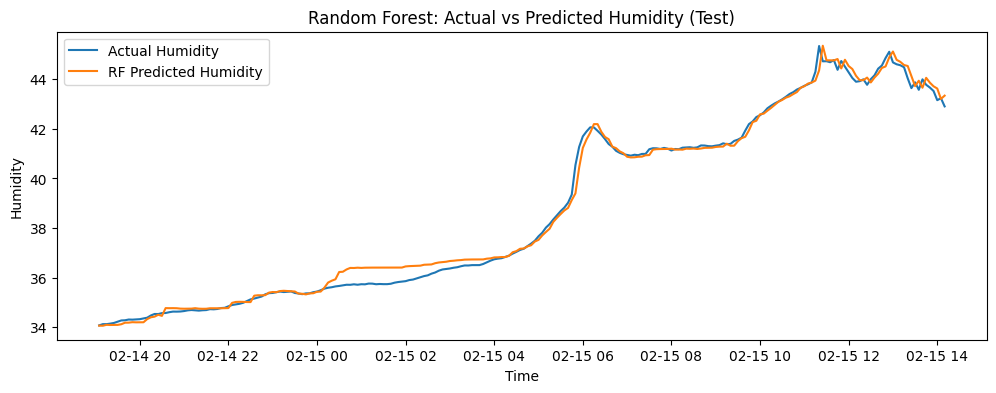

In [102]:
#Thomas
#Random Forest Regressor for one-step-ahead Humidity forecasting
#We enrich the lag feature set with calendar/time context from the DateTimeIndex to capture seasonality.

rf_df2 = rf_df.copy()

rf_df2["hour"] = rf_df2.index.hour
rf_df2["dayofweek"] = rf_df2.index.dayofweek
rf_df2["month"] = rf_df2.index.month
rf_df2["is_weekend"] = (rf_df2["dayofweek"] >= 5).astype(int)

def add_cyclical(df: pd.DataFrame, col: str, period: int) -> pd.DataFrame:
    df = df.copy()
    angle = 2 * np.pi * df[col] / period
    df[f"{col}_sin"] = np.sin(angle)
    df[f"{col}_cos"] = np.cos(angle)
    return df

rf_df2 = add_cyclical(rf_df2, "hour", 24)
rf_df2 = add_cyclical(rf_df2, "dayofweek", 7)
rf_df2 = add_cyclical(rf_df2, "month", 12)

# Final feature matrix
X_rf = rf_df2.drop(columns=["Humidity"])
y_rf = rf_df2["Humidity"]

#Time-ordered split to mimic real forecasting: train on early period, test on later period
split_idx = int(len(rf_df2) * 0.8)
X_train_rf, X_test_rf = X_rf.iloc[:split_idx], X_rf.iloc[split_idx:]
y_train_rf, y_test_rf = y_rf.iloc[:split_idx], y_rf.iloc[split_idx:]

rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_rf, y_train_rf)

#Baseline: persistence forecast 
baseline_pred = X_test_rf["Humidity_lag_1"].values

rf_pred = rf_model.predict(X_test_rf)

def regression_report(y_true, y_pred, label="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")
    return mae, rmse, r2

print("Evaluation (higher quality should beat persistence baseline):")
regression_report(y_test_rf, baseline_pred, label="baseline")
regression_report(y_test_rf, rf_pred, label="random_forest")

#Visual check: predicted vs actual
plt.figure(figsize=(12, 4))
plt.plot(y_test_rf.index, y_test_rf.values, label="Actual Humidity")
plt.plot(y_test_rf.index, rf_pred, label="RF Predicted Humidity")
plt.title("Random Forest: Actual vs Predicted Humidity (Test)")
plt.xlabel("Time")
plt.ylabel("Humidity")
plt.legend()
plt.show()

In [103]:
#Thomas
#Export prediction outputs for Tableau. This cell exports a CSV with Temperature and Humidity data
#The exported CSV saves locally so please locate it after running the notebook to plug into Tableau

out_dir = os.path.join("data", "processed")
os.makedirs(out_dir, exist_ok=True)

#Helper to enforce identical timestamp granularity before merging
def normalize_ts(s: pd.Series, freq: str = "5min") -> pd.Series:
    ts = pd.to_datetime(s)
    #floor to the nearest interval to avoid tiny mismatches
    return ts.dt.floor(freq)

#Temperature evaluation outputs
if "temp_results" not in globals():
    window = x_train.shape[1]
    n_features = x_train.shape[2]
    temp_idx = model_df.columns.get_loc("Temperature")

    y_pred_scaled = lstm_model.predict(x_val, verbose=0).reshape(-1)
    y_true_scaled = y_val.reshape(-1)

    def invert_single_feature(scaler, scaled_vec, feature_index, n_features):
        tmp = np.zeros((len(scaled_vec), n_features), dtype=float)
        tmp[:, feature_index] = scaled_vec
        inv = scaler.inverse_transform(tmp)
        return inv[:, feature_index]

    y_pred_temp = invert_single_feature(scaler, y_pred_scaled, temp_idx, n_features)
    y_true_temp = invert_single_feature(scaler, y_true_scaled, temp_idx, n_features)

    temp_ts = val_df.index[window: window + len(y_true_temp)]
    temp_results = pd.DataFrame({
        "timestamp": pd.to_datetime(temp_ts),
        "actual_temperature": y_true_temp,
        "pred_temperature": y_pred_temp
    }).set_index("timestamp")
    temp_results["temp_abs_error"] = (temp_results["actual_temperature"] - temp_results["pred_temperature"]).abs()

temp_out = temp_results.reset_index()
temp_out["timestamp"] = normalize_ts(temp_out["timestamp"], "5min")
#If flooring created duplicates, aggregate
temp_out = temp_out.groupby("timestamp", as_index=False).mean(numeric_only=True)

#Humidity outputs
rf_out = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(y_test_rf.index),
        "actual_humidity": y_test_rf.values,
        "pred_humidity": rf_pred,
    }
)
rf_out["humidity_abs_error"] = (rf_out["actual_humidity"] - rf_out["pred_humidity"]).abs()

rf_out["timestamp"] = normalize_ts(rf_out["timestamp"], "5min")
rf_out = rf_out.groupby("timestamp", as_index=False).mean(numeric_only=True)

#Merge eval series
out = pd.merge(temp_out, rf_out, on="timestamp", how="inner").sort_values("timestamp")

out_path = os.path.join(out_dir, "tableau_predictions.csv") #We can change this name as needed but I think this is suitable
out.to_csv(out_path, index=False)

print("Saved:", out_path)
print("Rows:", len(out))
print("Temp non-null rows:", out["actual_temperature"].notna().sum())
print("Humidity non-null rows:", out["actual_humidity"].notna().sum())

#Show a preview where temperature actually exists
display(out[out["actual_temperature"].notna()].head(5))

Saved: C:\Users\tommy\Downloads\tableau_predictions.csv
Rows: 220
Temp non-null rows: 220
Humidity non-null rows: 220


,timestamp,actual_temperature,pred_temperature,temp_abs_error,temp_abs_error_roll_1h,actual_humidity,pred_humidity,humidity_abs_error
0,2022-02-14 19:55:00,19.745000,19.868039,0.123038,0.123038,34.317333,34.201033,0.116300
1,2022-02-14 20:00:00,19.704668,19.828937,0.124269,0.123654,34.327934,34.203469,0.124465
2,2022-02-14 20:05:00,19.670332,19.794912,0.124580,0.123963,34.356331,34.203531,0.152800
3,2022-02-14 20:10:00,19.639667,19.761450,0.121783,0.123418,34.387600,34.330580,0.057020
4,2022-02-14 20:15:00,19.598665,19.720725,0.122060,0.123146,34.477165,34.404399,0.072766


### Tableau Rationale

Design choice: We export a single table keyed by timestamp so Tableau can create time-series visuals with minimal prep. The table includes actuals, predictions, and absolute error for both models to support KPI tiles and error charts.

### Final Project Summary

Overall, we selected a two model strategy to balance predictive power, interpretability, and operational usefulness in an IoT monitoring context. The preprocessing stage creates a reliable time indexed dataset that supports both sequence learning and feature engineered regression, which keeps the modeling comparison fair and makes the exported results consistent for Tableau. The LSTM is included to learn temporal dependencies directly from sequences, which is valuable when the underlying dynamics involve delayed responses and multivariate interactions. The random forest is included as a complementary method that leverages explicit lag and time features to capture persistence and seasonality while remaining easy to train and explain. The exported Tableau table is intentionally structured around a shared timestamp with actuals, predictions, and absolute error so the dashboard can present both system status and model quality over time in a way that is straightforward for an operator to interpret and act on.
